In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

In [19]:
data_dir = "PPMI_ds/"

files = {
    "diagnosis": "Primary_Clinical_Diagnosis_18Mar2025.csv",
    "parkinsonism": "Features_of_Parkinsonism_18Mar2025.csv",
    "rem": "Features_of_REM_Behavior_Disorder_18Mar2025.csv",
    "cgi": "Clinical_Global_Impression__CGI__-_Investigator_18Mar2025.csv",
    "exam": "General_Physical_Exam_18Mar2025.csv"
}

dfs = {name: pd.read_csv(f"{data_dir}/{fname}") for name, fname in files.items()}

# 🔹 Step 2: Clean general physical exam (pivot long format)
exam_df = dfs['exam'][['PATNO', 'PECAT', 'ABNORM']]
exam_wide = exam_df.pivot_table(index='PATNO', columns='PECAT', values='ABNORM', aggfunc='max')
exam_wide.columns = [f"ABNORM_{str(col).strip().replace(' ', '_')}" for col in exam_wide.columns]
exam_wide.reset_index(inplace=True)

# 🔹 Step 3: Prepare label (PRIMDIAG from diagnosis file)
label_df = dfs['diagnosis'][['PATNO', 'PRIMDIAG']].drop_duplicates(subset='PATNO')
label_df['label'] = label_df['PRIMDIAG'].apply(lambda x: 1 if x == 17 else 0)
label_df = label_df[['PATNO', 'label']]

# 🔹 Step 4: Process and aggregate other files (1 row per PATNO)
aggregated = []

for key in ['parkinsonism', 'rem', 'cgi']:
    df = dfs[key]
    df = df.drop(columns=[col for col in df.columns if col in ['EVENT_ID', 'INFODT', 'REC_ID', 'PAG_NAME', 'ORIG_ENTRY', 'LAST_UPDATE']], errors='ignore')
    df_grouped = df.groupby('PATNO').mean(numeric_only=True).reset_index()
    aggregated.append(df_grouped)

# 🔹 Step 5: Merge everything into one DataFrame
merged = label_df.copy()

for df in aggregated + [exam_wide]:
    merged = merged.merge(df, on='PATNO', how='left')

print("✅ Final merged shape:", merged.shape)
merged.to_csv("merged_clin.csv")

✅ Final merged shape: (4335, 22)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


X = merged.drop(columns=['PATNO', 'label'])
y = merged['label']

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

In [23]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_proba = logreg.predict_proba(X_test)[:, 1]

print("🔹 Logistic Regression")
print("✅ Accuracy:", accuracy_score(y_test, logreg_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, logreg_proba))
print(classification_report(y_test, logreg_pred))

🔹 Logistic Regression
✅ Accuracy: 0.76239907727797
📈 ROC AUC: 0.8476518394441342
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       597
           1       0.61      0.67      0.64       270

    accuracy                           0.76       867
   macro avg       0.73      0.74      0.73       867
weighted avg       0.77      0.76      0.77       867



In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest")
print("✅ Accuracy:", accuracy_score(y_test, rf_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, rf_proba))
print(classification_report(y_test, rf_pred))


🔹 Random Forest
✅ Accuracy: 0.803921568627451
📈 ROC AUC: 0.8720050871642162
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       597
           1       0.68      0.69      0.69       270

    accuracy                           0.80       867
   macro avg       0.77      0.77      0.77       867
weighted avg       0.80      0.80      0.80       867



In [25]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)[:, 1]

print("\n🔹 MLP Neural Network")
print("✅ Accuracy:", accuracy_score(y_test, mlp_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, mlp_proba))
print(classification_report(y_test, mlp_pred))


🔹 MLP Neural Network
✅ Accuracy: 0.7889273356401384
📈 ROC AUC: 0.8450586264656615
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       597
           1       0.65      0.70      0.67       270

    accuracy                           0.79       867
   macro avg       0.75      0.77      0.76       867
weighted avg       0.79      0.79      0.79       867



c:\Users\arsh0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


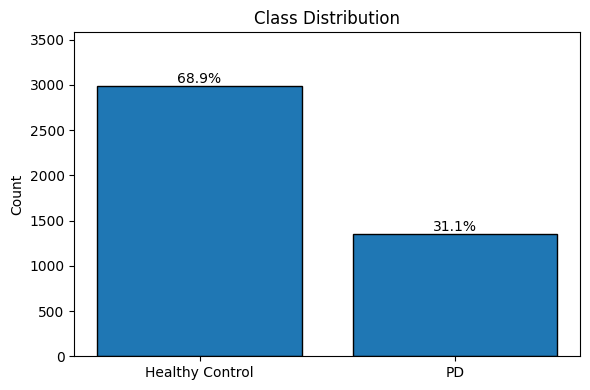

In [26]:
import matplotlib.pyplot as plt

# Use the y_test from previous context for class distribution
# For demo, assume y contains the full label array

# Simulate what y would look like
import numpy as np
from collections import Counter

# Reconstruct y as binary just for visualization
# Normally you'd pass your actual y Series here
# Assuming we already have 'y' from your session
try:
    label_counts = Counter(y)
except NameError:
    label_counts = Counter(y)

labels = ['Healthy Control', 'PD']
counts = [label_counts[0], label_counts[1]]
percentages = [count / sum(counts) * 100 for count in counts]

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, edgecolor='black')
plt.title('Class Distribution')
plt.ylabel('Count')

# Annotate with percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(counts) * 1.2)
plt.tight_layout()
plt.show()
